In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Outlier counts per column:
 BloodPressure               45
Insulin                     34
DiabetesPedigreeFunction    29
BMI                         19
Age                          9
Glucose                      5
Pregnancies                  4
SkinThickness                1
Outcome                      0
dtype: int64


Text(0.5, 1.0, 'Boxplots per feature')

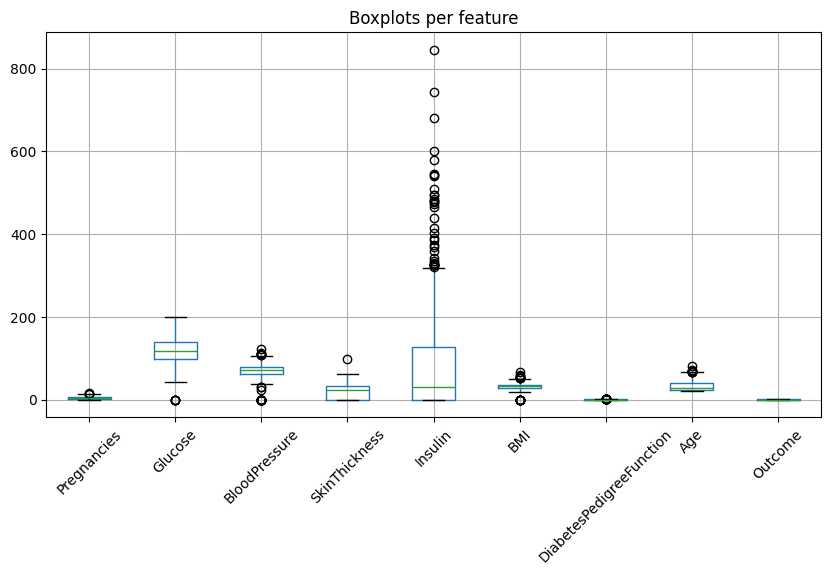

In [5]:
# Quick outlier scan and descriptive stats
display(df.describe())

# Simple IQR-based outlier count per column (without dropping anything)
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
outlier_mask = (df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))
outlier_counts = outlier_mask.sum().sort_values(ascending=False)
print("Outlier counts per column:\n", outlier_counts)

# Optional quick visualization
ax = df.boxplot(figsize=(10,5), rot=45)
ax.set_title("Boxplots per feature")

The presence of outliers was verified using descriptive statistics and the Interquartile Range (IQR) rule.  
As instructed, no data was removed or replaced because it is a healthcare dataset and every patient record is important.  
I kept the `StandardScaler` in the pipeline to normalize the magnitude between attributes and reduce the effect of different measurement scales.  
Optionally, `RobustScaler` could be tested since it is less sensitive to outliers, but the standard scaling approach was maintained for consistency.

# Regression

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)

Feature scaling was performed **after splitting the dataset** to avoid data leakage.  
Each split (70/30 and 60/40) was scaled separately using `StandardScaler`.  
This ensures that statistics from the test set are not used during training, maintaining model integrity.

In [7]:
model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
model2 = LogisticRegression(max_iter=1000, solver="lbfgs")
model2.fit(X_train_scaled2, y_train2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [9]:
y_pred = model.predict(X_test_scaled)
y_pred2 = model2.predict(X_test_scaled2)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

cm2 = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix 2:\n", cm2)

Confusion matrix:
 [[130  20]
 [ 39  42]]
Confusion matrix 2:
 [[169  32]
 [ 49  58]]


In [10]:
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("\nClassification report 2:\n", classification_report(y_test2, y_pred2, digits=4))


Classification report:
               precision    recall  f1-score   support

           0     0.7692    0.8667    0.8150       150
           1     0.6774    0.5185    0.5874        81

    accuracy                         0.7446       231
   macro avg     0.7233    0.6926    0.7012       231
weighted avg     0.7370    0.7446    0.7352       231


Classification report 2:
               precision    recall  f1-score   support

           0     0.7752    0.8408    0.8067       201
           1     0.6444    0.5421    0.5888       107

    accuracy                         0.7370       308
   macro avg     0.7098    0.6914    0.6978       308
weighted avg     0.7298    0.7370    0.7310       308



# KNN

In [11]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

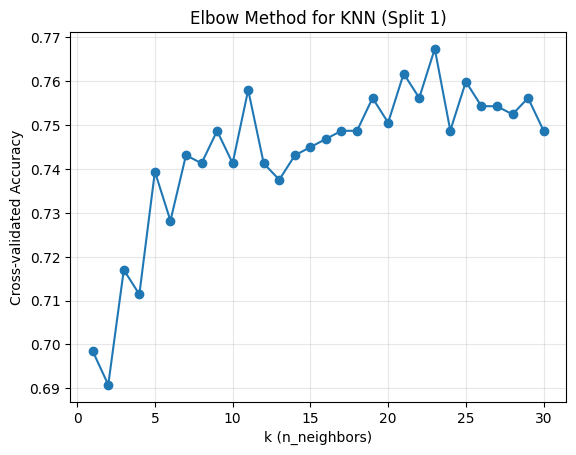

Best k = 23 with mean CV accuracy = 0.7674


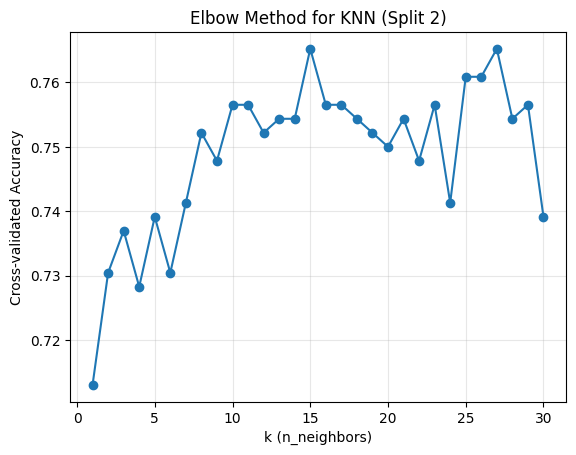

Best k (split 2) = 15 with mean CV accuracy = 0.7652


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)

k_values = range(1, 31)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
for k in k_values:
    pipe.set_params(knn__n_neighbors=k)
    cv_score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    scores.append(cv_score.mean())

best_k = k_values[np.argmax(scores)]
best_score = max(scores)

plt.plot(k_values, scores, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Cross-validated Accuracy")
plt.title("Elbow Method for KNN (Split 1)")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best k = {best_k} with mean CV accuracy = {best_score:.4f}")

scores2 = []
for k in k_values:
    pipe.set_params(knn__n_neighbors=k)
    cv_score2 = cross_val_score(pipe, X_train2, y_train2, cv=cv, scoring="accuracy")
    scores2.append(cv_score2.mean())

best_k2 = k_values[np.argmax(scores2)]
best_score2 = max(scores2)

plt.plot(k_values, scores2, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Cross-validated Accuracy")
plt.title("Elbow Method for KNN (Split 2)")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best k (split 2) = {best_k2} with mean CV accuracy = {best_score2:.4f}")

The elbow method was applied to identify the optimal number of neighbors (`k`) for both 70/30 and 60/40 splits.  
Cross-validation (5 folds) was used to compute average accuracy scores for each `k`, preventing bias from a single split.  
The plots show how accuracy changes as `k` increases, helping to choose the best balance between model complexity and performance.

In [13]:
df.describe()
# Se quiser algo rápido por coluna:
iqr = df.quantile(0.75) - df.quantile(0.25)
outlier_mask = (df < (df.quantile(0.25) - 1.5*iqr)) | (df > (df.quantile(0.75) + 1.5*iqr))
outlier_mask.sum().sort_values(ascending=False)

BloodPressure               45
Insulin                     34
DiabetesPedigreeFunction    29
BMI                         19
Age                          9
Glucose                      5
Pregnancies                  4
SkinThickness                1
Outcome                      0
dtype: int64

In [14]:
# Evaluate KNN with best_k on both splits
# Split 1
pipe.set_params(knn__n_neighbors=best_k)
pipe.fit(X_train, y_train)  # scaling happens inside the pipe
y_pred_knn = pipe.predict(X_test)

print("KNN Split 1 - Classification report")
print(classification_report(y_test, y_pred_knn, digits=4))

cm_knn1 = confusion_matrix(y_test, y_pred_knn)
print("KNN Split 1 - Confusion matrix:\n", cm_knn1)

# Split 2
pipe.set_params(knn__n_neighbors=best_k2)
pipe.fit(X_train2, y_train2)
y_pred_knn2 = pipe.predict(X_test2)

print("\nKNN Split 2 - Classification report")
print(classification_report(y_test2, y_pred_knn2, digits=4))

cm_knn2 = confusion_matrix(y_test2, y_pred_knn2)
print("KNN Split 2 - Confusion matrix:\n", cm_knn2)

KNN Split 1 - Classification report
              precision    recall  f1-score   support

           0     0.7586    0.8800    0.8148       150
           1     0.6842    0.4815    0.5652        81

    accuracy                         0.7403       231
   macro avg     0.7214    0.6807    0.6900       231
weighted avg     0.7325    0.7403    0.7273       231

KNN Split 1 - Confusion matrix:
 [[132  18]
 [ 42  39]]

KNN Split 2 - Classification report
              precision    recall  f1-score   support

           0     0.7729    0.8806    0.8233       201
           1     0.6962    0.5140    0.5914       107

    accuracy                         0.7532       308
   macro avg     0.7346    0.6973    0.7073       308
weighted avg     0.7463    0.7532    0.7427       308

KNN Split 2 - Confusion matrix:
 [[177  24]
 [ 52  55]]


K-Nearest Neighbors (KNN) was trained with the best `k` value from each elbow analysis.  
Performance metrics such as precision, recall, F1-score, and confusion matrix were compared between the 70/30 and 60/40 splits.  
Both configurations provide insights into how the model generalizes when given more or fewer training samples.